In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Загрузка изображения

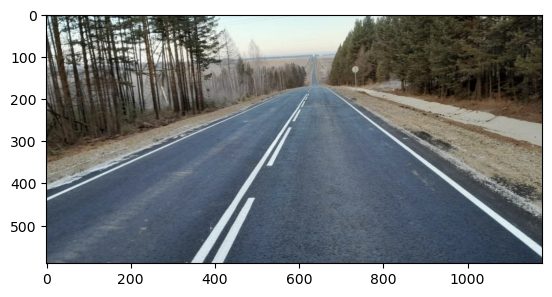

In [3]:
image = cv2.imread('data/road1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Предобработка изображения и получение границ

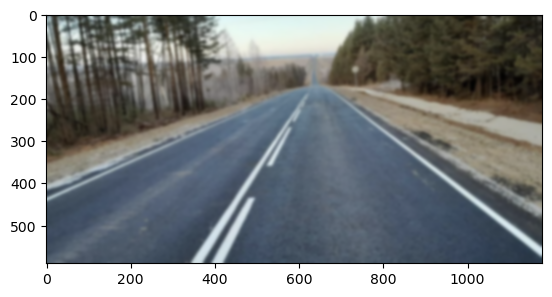

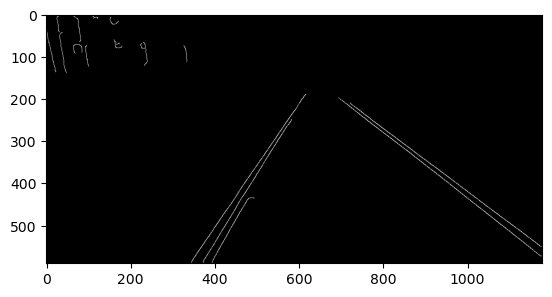

In [5]:
blur = cv2.GaussianBlur(gray, (19, 19), 0)
edges = cv2.Canny(blur, 50, 200)

plt.imshow(blur, cmap = "gray")
plt.show()
plt.imshow(edges, cmap = "gray")
plt.show()

### Поиск линий с помошью преобразования Хафа

Подбор параметров для преобразования Хафа

In [8]:
def print_hough_lines(image, edges, threshold_, minLineLength_, maxLineGap_):
    im_ = image.copy()
    
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=threshold_, minLineLength=minLineLength_, maxLineGap=maxLineGap_)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(im_, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
        plt.imshow(cv2.cvtColor(im_, cv2.COLOR_BGR2RGB))
        plt.title(f"threshold = {threshold_}, minLineLength = {minLineLength_}, maxLineGap = {maxLineGap_}")
        plt.show()

In [9]:
#for threshold in range(10, 220, 100):
#    for minLineLength in range(200, 410, 100):
#        for maxLineGap in range(150, 310, 50):
#            print_hough_lines(image, edges, threshold, minLineLength, maxLineGap)

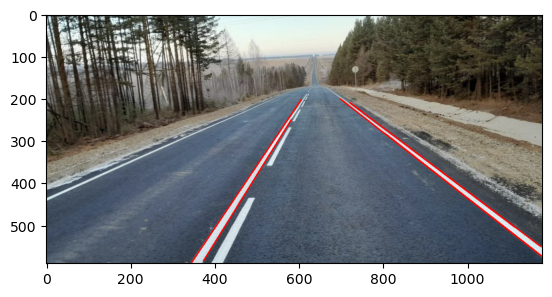

In [10]:
best_threshold = 110
best_minLineLength = 300
best_maxLineGap = 150

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=best_threshold, minLineLength=best_minLineLength, maxLineGap=best_maxLineGap)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### Поиск точки схода

In [12]:
def find_not_parallel(lines, distance_threshold=60, angle_threshold=0.1):
    filtered_lines = []
    
    def compute_angle(x1, y1, x2, y2):
        return np.arctan2(y2 - y1, x2 - x1)
    
    def is_parallel(line1, line2):
        x1, y1, x2, y2 = line1
        x3, y3, x4, y4 = line2
        
        angle1 = compute_angle(x1, y1, x2, y2)
        angle2 = compute_angle(x3, y3, x4, y4)
        distance = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
        
        return (abs(angle1 - angle2) < angle_threshold)
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        similar_found = False
        
        for existing_line in filtered_lines:
            if is_parallel(existing_line, (x1, y1, x2, y2)):
                similar_found = True
                break
        
        if not similar_found:
            filtered_lines.append([x1, y1, x2, y2])
    
    return filtered_lines

In [13]:
not_parallel_lines = find_not_parallel(lines)

In [14]:
def find_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None

    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
    return int(px), int(py)

In [15]:
intersections = []
for i in range(len(not_parallel_lines)):
    for j in range(i+1, len(not_parallel_lines)):
        intersection = find_intersection(not_parallel_lines[i], not_parallel_lines[j])
        if intersection is not None:
            intersections.append(intersection)

In [16]:
if intersections:
    avg_x = int(np.mean([pt[0] for pt in intersections]))
    avg_y = int(np.mean([pt[1] for pt in intersections]))
    cv2.circle(image, (avg_x, avg_y), 10, (0, 255, 255), -1)

### Результат

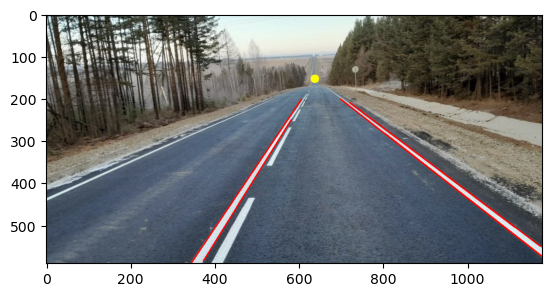

In [18]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))